# Power analysis preparation

In this notebook, we prepare the aggregated datasets for the power analysis on different FDR levels.

The FDR-corrected and aggregated data can be found as "benchmark_results_fdr_xx", "sccoda_effects_fdr_xx", and "results_grouped_fdr_xx" in the data folder.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import re
import shutil
import pickle as pkl


sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

In [2]:
# read data
results_path = "../../sccoda_benchmark_data_review/overall_benchmark/"

# Join all together
res = pd.read_csv(results_path + "benchmark_results", index_col=0)

     n_cell_types  n_cells  n_controls  n_cases  Base  Increase  \
0               5     5000           2        9    20        80   
1               5     5000           2        9    20        80   
2               5     5000           2        9    20        80   
3               5     5000           2        9    20        80   
4               5     5000           2        9    20        80   
..            ...      ...         ...      ...   ...       ...   
495             5     5000           8        8    30        70   
496             5     5000           8        8    30        70   
497             5     5000           8        8    30        70   
498             5     5000           8        8    30        70   
499             5     5000           8        8    30        70   

     log-fold increase                                b_true  \
0                 2.32  [-5.521 -1.39  -1.39  -1.39  -1.39 ]   
1                 2.32  [-5.521 -1.39  -1.39  -1.39  -1.39 ]   
2  

In [4]:
def get_scores(df):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df["tp"].astype("float64")
    tn = df["tn"].astype("float64")
    fp = df["fp"].astype("float64")
    fn = df["fn"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df["tpr"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df["tnr"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df["precision"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df["fdr"] = fdr
    acc = (tp + tn) / (tp + tn + fp + fn).fillna(0)
    df["accuracy"] = acc

    df["youden"] = tpr + tnr - 1
    df["f1_score"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df["mcc"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df

We evaluate scCODA's result on each generated dataset individually benchmark on the FDR levels of 0.05, 0.1 and 0.2.
Then, we aggregate the true positive, false positive, true negative, and false negative numbers
from all datasets that were generated with the same parameters (10 repetitions each), and calculate the classification metrics on the aggregated results.

In [7]:
def opt_thresh(result, alpha):

    incs = np.array(result.loc[result["Inclusion probability"] > 0, "Inclusion probability"])
    incs[::-1].sort()

    for c in np.unique(incs):
        fdr = np.mean(1-incs[incs>=c])

        if fdr < alpha:
            # ceiling with 3 decimals precision
            c = np.floor(c * 10**3) / 10**3
            return c, fdr
    return 1., 0

In [22]:
def apply_thresholds(res_path, alpha):

    data_names = os.listdir(res_path)

    sccoda_effects = []
    all_res = []

    for name in data_names:
        if name.startswith("scCODA"):
            print(name)
            with open(res_path + name, "rb") as f:
                temp = pkl.load(f)

            res = temp["results"].copy()
            i = 0
            for e in temp["effects"]:
                t, _ = opt_thresh(e, alpha)
                e["threshold"] = t

                e["new_fp"] = [1 if x>=t else 0 for x in e["Inclusion probability"]]

                tp = sum([e["new_fp"][0] != 0])
                fn = sum([e["new_fp"][0] == 0])
                tn = sum([e["new_fp"][k] == 0 for k in [1,2,3,4]])
                fp = sum([e["new_fp"][k] != 0 for k in [1,2,3,4]])

                res.loc[i,"tp"] = tp
                res.loc[i,"tn"] = tn
                res.loc[i,"fp"] = fp
                res.loc[i,"fn"] = fn

                for par in ["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]:
                    e["par"] = res.loc[i, par]

                sccoda_effects.append(e)

                i += 1

            all_res.append(res)


    all_results = pd.concat(all_res)
    sccoda_conc = pd.concat(sccoda_effects, keys=list(range(len(sccoda_effects))), names=["dataset", "Covariate", "Cell Type"])

    return sccoda_conc, all_results

1.0


In [16]:
eff_01, res_01 = apply_thresholds(results_path, 0.1)

res_01_ = get_scores(res_01)

scCODA_results_203.pkl
scCODA_results_217.pkl
scCODA_results_377.pkl
scCODA_results_363.pkl
scCODA_results_388.pkl
scCODA_results_175.pkl
scCODA_results_161.pkl
scCODA_results_149.pkl
scCODA_results_47.pkl
scCODA_results_53.pkl
scCODA_results_84.pkl
scCODA_results_90.pkl
scCODA_results_91.pkl
scCODA_results_85.pkl
scCODA_results_52.pkl
scCODA_results_148.pkl
scCODA_results_46.pkl
scCODA_results_160.pkl
scCODA_results_174.pkl
scCODA_results_389.pkl
scCODA_results_362.pkl
scCODA_results_376.pkl
scCODA_results_216.pkl
scCODA_results_202.pkl
scCODA_results_214.pkl
scCODA_results_200.pkl
scCODA_results_360.pkl
scCODA_results_374.pkl
scCODA_results_348.pkl
scCODA_results_162.pkl
scCODA_results_78.pkl
scCODA_results_176.pkl
scCODA_results_50.pkl
scCODA_results_44.pkl
scCODA_results_93.pkl
scCODA_results_87.pkl
scCODA_results_189.pkl
scCODA_results_86.pkl
scCODA_results_188.pkl
scCODA_results_92.pkl
scCODA_results_45.pkl
scCODA_results_51.pkl
scCODA_results_79.pkl
scCODA_results_177.pkl
scCODA

44922

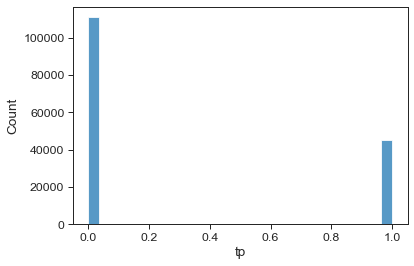

In [17]:
res_01_.to_csv(results_path + "benchmark_results_fdr_01")
eff_01.to_csv(results_path + "sccoda_effects_fdr_01")

res_01_grouped = res_01_.groupby(["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]).agg(
    {"tp": "sum",
    "tn": "sum",
    "fp": "sum",
    "fn": "sum"}
).reset_index()

res_01_grouped = get_scores(res_01_grouped)

res_01_grouped.to_csv(results_path + "results_grouped_fdr_01.csv")



In [10]:
eff_005, res_005 = apply_thresholds(results_path, 0.05)

res_005_ = get_scores(res_005)

scCODA_results_203.pkl
scCODA_results_217.pkl
scCODA_results_377.pkl
scCODA_results_363.pkl
scCODA_results_388.pkl
scCODA_results_175.pkl
scCODA_results_161.pkl
scCODA_results_149.pkl
scCODA_results_47.pkl
scCODA_results_53.pkl
scCODA_results_84.pkl
scCODA_results_90.pkl
scCODA_results_91.pkl
scCODA_results_85.pkl
scCODA_results_52.pkl
scCODA_results_148.pkl
scCODA_results_46.pkl
scCODA_results_160.pkl
scCODA_results_174.pkl
scCODA_results_389.pkl
scCODA_results_362.pkl
scCODA_results_376.pkl
scCODA_results_216.pkl
scCODA_results_202.pkl
scCODA_results_214.pkl
scCODA_results_200.pkl
scCODA_results_360.pkl
scCODA_results_374.pkl
scCODA_results_348.pkl
scCODA_results_162.pkl
scCODA_results_78.pkl
scCODA_results_176.pkl
scCODA_results_50.pkl
scCODA_results_44.pkl
scCODA_results_93.pkl
scCODA_results_87.pkl
scCODA_results_189.pkl
scCODA_results_86.pkl
scCODA_results_188.pkl
scCODA_results_92.pkl
scCODA_results_45.pkl
scCODA_results_51.pkl
scCODA_results_79.pkl
scCODA_results_177.pkl
scCODA

In [129]:
res_005_.to_csv(results_path + "benchmark_results_fdr_005")
eff_005.to_csv(results_path + "sccoda_effects_fdr_005")

res_005_grouped = res_005_.groupby(["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]).agg(
    {"tp": "sum",
    "tn": "sum",
    "fp": "sum",
    "fn": "sum"}
).reset_index()

res_005_grouped = get_scores(res_005_grouped)

res_005_grouped.to_csv(results_path + "results_grouped_fdr_005.csv")

In [43]:
eff_02, res_02 = apply_thresholds(results_path, 0.2)

res_02_ = get_scores(res_02)

res_02_.to_csv(results_path + "benchmark_results_fdr_02")

scCODA_results_203.pkl
scCODA_results_217.pkl
scCODA_results_377.pkl
scCODA_results_363.pkl
scCODA_results_388.pkl
scCODA_results_175.pkl
scCODA_results_161.pkl
scCODA_results_149.pkl
scCODA_results_47.pkl
scCODA_results_53.pkl
scCODA_results_84.pkl
scCODA_results_90.pkl
scCODA_results_91.pkl
scCODA_results_85.pkl
scCODA_results_52.pkl
scCODA_results_148.pkl
scCODA_results_46.pkl
scCODA_results_160.pkl
scCODA_results_174.pkl
scCODA_results_389.pkl
scCODA_results_362.pkl
scCODA_results_376.pkl
scCODA_results_216.pkl
scCODA_results_202.pkl
scCODA_results_214.pkl
scCODA_results_200.pkl
scCODA_results_360.pkl
scCODA_results_374.pkl
scCODA_results_348.pkl
scCODA_results_162.pkl
scCODA_results_78.pkl
scCODA_results_176.pkl
scCODA_results_50.pkl
scCODA_results_44.pkl
scCODA_results_93.pkl
scCODA_results_87.pkl
scCODA_results_189.pkl
scCODA_results_86.pkl
scCODA_results_188.pkl
scCODA_results_92.pkl
scCODA_results_45.pkl
scCODA_results_51.pkl
scCODA_results_79.pkl
scCODA_results_177.pkl
scCODA

NameError: name 'eff_005' is not defined

In [44]:
eff_02.to_csv(results_path + "sccoda_effects_fdr_02")

res_02_grouped = res_02_.groupby(["n_controls", "n_cases", "Base", "Increase", "log-fold increase"]).agg(
    {"tp": "sum",
    "tn": "sum",
    "fp": "sum",
    "fn": "sum"}
).reset_index()

res_02_grouped = get_scores(res_02_grouped)

res_02_grouped.to_csv(results_path + "results_grouped_fdr_02.csv")